## 1. Connect to Aca-Py Agent

In [1]:
%autoawait
import time
import asyncio

IPython autoawait is `on`, and set to use `asyncio`


In [2]:
from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_BASE = ""

WEBHOOK_PORT = 8022
ADMIN_URL = "http://issuer-agent:8021"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)

In [3]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def messages_handler(payload):
    connection_id = payload["connection_id"]
    asyncio.get_event_loop().create_task(agent_controller.messaging.send_message(connection_id, "This is a response from Bob"))
    print("Handle message", payload, connection_id)


message_listener = {
    "handler": messages_handler,
    "topic": "basicmessages"
}

def connections_handler(payload):
    connection_id = payload["connection_id"]
#     asyncio.get_event_loop().create_task(agent_controller.messaging.send_message(connection_id, "This is a response from Bob"))
    print("Connection message", payload, connection_id)


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

def proof_handler(payload):
    print("Handle present proof")
    print(payload)

proof_listener = {
    "topic": "present_proof",
    "handler": proof_handler
}

agent_controller.register_listeners([cred_listener,message_listener,connection_listener,proof_listener], defaults=True)


Connection message {'invitation_key': '5oFmgRME7891Zz5nBaVKLTeWjpdGhUpGNFzWZJEMwV8t', 'initiator': 'self', 'updated_at': '2020-09-11 13:18:23.726847Z', 'invitation_mode': 'once', 'routing_state': 'none', 'accept': 'auto', 'state': 'invitation', 'their_role': 'admin', 'created_at': '2020-09-11 13:18:23.726847Z', 'connection_id': 'a433d68c-e13f-4717-b1fc-ae10edb309d9'} a433d68c-e13f-4717-b1fc-ae10edb309d9


# See if any TAA agreements exist on the ledger

In [4]:
issuer_response = await agent_controller.ledger.get_taa()
print(issuer_response)

{'result': {'aml_record': {'amlContext': 'https://raw.githubusercontent.com/sovrin-foundation/sovrin/master/TAA/AML.md', 'version': '0.1', 'aml': {'click_agreement': 'The agreement was displayed and then agreed to by typing or clicking acceptance.', 'at_submission': 'The agreement was reviewed by the user and accepted at the time of submission of this transaction.', 'wallet_agreement': 'The agreement was reviewed by the user and this affirmation was persisted in the user’s wallet for use during future submissions.', 'on_file': 'An authorized person accepted the agreement, and such acceptance is on file with the user’s organization.', 'service_agreement': 'The agreement was included in the terms and conditions the Transaction Author accepted as part of contracting a service.', 'product_eula': 'The agreement was included in the software product’s terms and conditions as part of the license to the user.', 'for_session': 'The agreement was reviewed by the user and accepted at some point in

# Get current DID

In [5]:
# Get DIDs
response = await agent_controller.wallet.get_dids()
did_object = response['results']
print("Current DIDs", did_object)

Current DIDs []


# Get current public DID

In [6]:
response = await agent_controller.wallet.get_public_did()
print(response)

{'result': None}


# Generate a new DID

In [7]:
# generate new DID
response = await agent_controller.wallet.create_did()

did_object = response['result']
print("New DID", did_object)

New DID {'did': 'Uy9menKrGwyUrkoGHJAaFi', 'verkey': 'GF8Q43WEtwEFL3kZ6xAXhdj6coQiC52ehoTz3Qy8p6G5', 'public': False}


# Write DID to Sovrin Stagingnet
Visit [Sovrin Selfserve Portal](https://selfserve.sovrin.org) for more information. We have provided an automated process to write DIDs to Stagingnet in the step below.

In [8]:
# write new DID to Sovrin Stagingnet
import requests
import json 

url = 'https://selfserve.sovrin.org/nym'

payload = {"network":"stagingnet","did": did_object["did"],"verkey":did_object["verkey"],"paymentaddr":""}

# Adding empty header as parameters are being sent in payload
headers = {}

r = requests.post(url, data=json.dumps(payload), headers=headers)
print(r.json())
print(r.status_code)

{'statusCode': 200, 'headers': {'Access-Control-Allow-Origin': '*'}, 'body': '{"statusCode": 200, "Uy9menKrGwyUrkoGHJAaFi": {"status": "Success", "statusCode": 200, "reason": "Successfully wrote NYM identified by Uy9menKrGwyUrkoGHJAaFi to the ledger with role ENDORSER"}}'}
200


# Accepting the TAA Agreement

In [9]:
TAA = {
  "version": "2.0",
  "mechanism": "service_agreement",
"text": "﻿# Transaction Author Agreement V2\nhttps://sovrin.org/\n\n\n## Summary:\n\n\nThis summary is provided to help you understand your obligations when writing to\nthe Sovrin Ledger Networks-it does not have any legal effect or replace the full\nlegal text of the agreement provided below it.\n\n\n- This agreement grants you permission to write data to the Sovrin Ledger\n  Networks under certain terms and conditions.\n\n\n- You represent and warrant that the data you are writing does not violate any\n  applicable laws or infringe the rights of any other party.\n\n\n- You understand the data you are writing is public and permanent and there can\n  be no guarantee of erasure. This includes public keys and payment addresses.\n\n\n- If it is determined that the data you wrote violated this agreement, the\n  operators of the network can take steps to block it from public access.\n\n\n- The Sovrin Foundation makes no promises about the reliability or correctness\n  of the data being stored on the Sovrin Ledger Networks or the operation of the\n  Sovrin Ledger Networks.\n\n\n--------------------------------------------------------------------------------\n\n\n## Agreement: Approved by the Sovrin Board of Trustees 04 December 2019\n\n\nThis Transaction Author Agreement (the \"**Agreement**\") is entered into on the\ndate you accepted this Agreement (the \"**Effective Date**\") between the Sovrin\nFoundation, a nonprofit corporation organized under the laws of the State of\nUtah, United States of America (\"**Sovrin Foundation**\"), and you\n(\"**Transaction Author**\"), either an entity or a natural person acting as\nan Individual. Sovrin Foundation and Transaction Author are individually\nreferred to herein as a  \"Party\" and collectively as the  \"Parties\". All\nreferences to \"you\" throughout this Agreement will include that person or\nentity. You represent that you are authorized to accept this Agreement on that\nperson’s or entity’s behalf, and in the event you or the person or entity\nviolates this Agreement, the person or entity agrees to be responsible to the\nSovrin Foundation.\n\n\nBy clicking \"Accept\" or similar or writing Transactions to the Sovrin Ledger\nNetworks, Transaction Author agrees to be bound by this Agreement and all terms\nincorporated by reference. If Transaction Author does not agree to this\nAgreement in its entirety, do not click \"Accept\" or write Transactions to the\nSovrin Ledger Networks.\n\n\nIf Sovrin Foundation makes material changes to this Agreement, Sovrin Foundation will notify you\nby posting a notice on Sovrin Foundation’s website prior to the effective date of the changes. \nBy continuing to act as a Transaction Author or by otherwise writing Transactions on the\nSovrin Ledger Networks after Sovrin Foundation posts changes to their website, you agree to be\nbound by the revised Agreement.\n\n\nWHEREAS, Transaction Author desires to write Transactions to the Sovrin\nLedger Networks (each a \"**Transaction**\"); and\n\n\nWHEREAS, subject to Transaction Author complying with the terms and\nconditions of this Agreement, Sovrin Foundation grants permission to \nTransaction Author to write Transactions to the Sovrin Ledger Networks;\n\n\nFOR GOOD AND VALUABLE CONSIDERATION, THE SUFFICIENCY OF WHICH IS HEREBY\nACKNOWLEDGED, THE PARTIES AGREE AS FOLLOWS:\n\n\n\n\n## 1) Definitions\n\n\na. \"**Data Protection Laws**\" means the GDPR and any other data protection and\nprivacy laws, regulations, and regulatory requirements applicable to a party\nunder this Agreement.\n\n\nb. \"**GDPR**\" means the General Data Protection Regulation (EU) 2016/679\non the protection of natural persons with regard to the Processing of personal\ndata and on the free movement of such data, and repealing Directive 95/46/EC,\nand any amendment or replacement to it.\n\n\nc. \"**Impermissible Personal Data**\" means the Personal Data that\nTransaction Author writes to the Sovrin Ledger Networks that is not\nPermissible Personal Data.\n\n\nd. \"**Personal Data Transactions**\" has the meaning set forth in Section 3\nbelow.\n\n\ne. \"**Permissible Personal Data**\" means Personal Data that Transaction\nAuthor writes to the Sovrin Ledger Networks that is permitted under this\nAgreement and the Sovrin Governance Framework (including the\n[Sovrin Ledger Access Policies](https://sovrin.org/wp-content/uploads/Sovrin-Ledger-Access-Policies-V1.pdf)).\n\n\nf. \"**Personal Data**\" means information that relates, directly or\nindirectly, to a data subject, including without limitation, names, email\naddresses, postal addresses, identification numbers, location data, online\nidentifiers or one or more factors specific to the physical, physiological,\ngenetic, mental, economic, cultural or social identity of the data subject.\n\n\ng. \"**Process**\" or \"**Processing**\" means any operation or set of\noperations which is performed on Transactions data, whether or not by\nautomated means, such as the access, collection, use, storage, disclosure,\ndissemination, combination, recording, organization, structuring, adaption,\nalteration, copying, transfer, retrieval, consultation, disposal, restriction,\nerasure and/or destruction of Transactions data.\n\n\nh. \"**Sovrin Governance Framework**\" means Sovrin Foundation’s\ngovernance policies and rules available at\nhttps://sovrin.org/governance-framework/ or any successor website.\n\n\nUnless otherwise defined above, all capitalized terms used in this Agreement\nshall have the meanings given to them in this Agreement or in the Sovrin\nGovernance Framework and corresponding Sovrin Glossary. The Sovrin Governance\nFramework and Sovrin Glossary is incorporated into this Agreement by reference\nonly for purposes of use of such defined terms.\n\n\n\n\n## 2) Permission to Write to the Sovrin Ledger Networks\n\n\na. Sovrin Foundation hereby grants to Transaction Author a non-exclusive,\nnon-assignable, non-sublicensable, royalty free, revocable license to write to\nand use the Sovrin Ledger Networks in accordance with this Agreement and the\nSovrin Governance Framework.\n\n\nb. When authoring Transactions under the policy of Permissioned Write Access,\na Transaction Author may only write to the Sovrin Ledger Networks by using an\nauthorized Transaction Endorser. In the event that Sovrin Foundation enables\nPublic Write Access to the Sovrin Ledger Networks, Transaction Author will\nnot need a Transaction Endorser to endorse a Transaction.\n\n\nc. Once an initial Transaction has been written to one of the Sovrin Ledger\nNetworks by Transaction Author (\"**Initial Transaction**\"), the\nTransaction Author is granted permission to make additional Transactions to\nupdate the state of a previous Transaction (\"**Update Transactions**\"). Please\nnote, an Update Transaction does not remove the Initial Transaction, which\nwill remain on the Sovrin Ledger due to its immutability and may remain on\nSovrin Test Networks unless they are reset. Transaction Author may make Update\nTransactions if and only if Transaction Author was the author of the\nInitial Transaction. Update Transactions are Transactions and are subject to\nall the terms of this Agreement.\n\n\n\n\n## 3) Transaction Author Obligations\n\n\na. With regard to all Transactions, Transaction Author will:\n\n\n  1. comply with any requirements imposed by the Transaction Endorser on the\n  Transaction Author and any Transactions endorsed by the Transaction\n  Endorser;\n\n\n  2. not write Transactions containing Personal Data until Sovrin Foundation\n  approves Public Write Access and permits Transactions to contain Personal\n  Data pursuant to Section 3(b) below.\n\n\nb. If Sovrin Foundation approves Public Write Access and permits\nTransaction Authors to write Transactions that contain Permissible Personal\nData (\"**Personal Data Transactions**\"), then Transaction Author expressly\nagrees that:\n\n\n  1. It will not write any Transactions that contain Impermissible Personal\n  Data to the Sovrin Ledger Networks;\n\n\n  2. it is an independent data controller (as defined in the GDPR) of the\n  Personal Data Transactions and will be responsible for the lawfulness of the\n  Processing of such data in compliance with the Data Protection Laws;\n\n\n  3. it acknowledges and will notify all data subjects whose Personal Data it\n  Processes that functions inherent in blockchain technology may render\n  fulfilling data subject requests difficult or impossible. For example, due\n  to blockchain’s immutability, data stored on a blockchain generally cannot\n  be removed or altered once the data is confirmed on the blockchain;\n\n\n  4. it irrevocably waives any and all claims, rights and/or obligations it\n  may have now or in the future against Sovrin Foundation as a result of\n  being unable to fulfill data subject requests in accordance with Data\n  Protection Laws;\n\n\n  5. it agrees to be bound by the terms and conditions applicable to\n  Transaction Author as a controller of Personal Data Transactions under the\n  Data Processing Agreements with Stewards and Transaction Endorsers, each in\n  their roles as processors under the GDPR, and attached as Appendices A and B\n  (the \"**DPAs**\");\n\n\n  6. that Sovrin Foundation has the right to enter into the DPAs on its\n  behalf and the DPAs are made a part of the Agreement in their entirety;\n\n\n  7. by signing this Agreement, each Party is deemed to have signed the DPAs,\n  including the Standard Contractual Clauses with Sovrin Foundation and\n  Transaction Author as the \"Data exporter\", and with either a Steward or a\n  Transaction Endorser as \"Data importer\", as applicable;\n\n\n  8. at Sovrin Foundation’s request, Transaction Author will reimburse\n  Sovrin Foundation for any costs incurred by Sovrin Foundation in\n  enforcing Transaction Author’s rights under the GDPR, including but not\n  limited to fulfillment of data subject rights, rights of oversight and\n  audit, etc.; and\n\n\n  9. it irrevocably waives any and all claims that it may have now or in the\n  future that Sovrin Foundation lacks the rights to enter into the DPAs on\n  its behalf and bind Transaction Author to the DPAs’ terms and conditions,\n  including the limitation of liability therein.\n\n\n\n\n## 4) Term and Termination\n\n\na. This Agreement commences on the Effective Date and shall remain in force\nuntil terminated by either Party pursuant to this **Section 4 (Term and\nTermination)**.\n\n\nb. Either Party may terminate this Agreement: (i) if the other Party has\nmaterially defaulted in the performance of any of its obligations under this\nAgreement and has not cured such default within fifteen (15) business days of\nreceipt of written notice from the non-defaulting Party of such default or\n(ii) immediately in the event of any government sanctions or other legal\nmeasures that make it unlawful for Transaction Author to write Transactions to\nthe Sovrin Ledger Networks.\n\n\nc. Additionally, Transaction Author may terminate this Agreement upon 30 days'\nadvance written notice to Sovrin Foundation and ceasing all use of the\nSovrin Ledger Networks.\n\n\nd. Upon termination or expiration of this Agreement for any reason the rights\ngranted to Transaction Author by Sovrin Foundation under this Agreement\nautomatically terminate.\n\n\n\n\n## 5) Representations and Warranties; Disclaimer\n\n\na. By Sovrin Foundation.\n\n\n  1. THE SOVRIN LEDGER NETWORKS AND THE SOVRIN NETWORK ARE PROVIDED AS-IS WITH\n  ALL FAULTS. TO THE FULLEST EXTENT PERMITTED BY APPLICABLE LAW, THE SOVRIN\n  FOUNDATION MAKES NO REPRESENTATION OR WARRANTY CONCERNING THE ACCURACY,\n  RELIABILITY, OR COMPLETENESS OF ANY INFORMATION OR DATA OBTAINED OR DERIVED\n  THROUGH THE USE OF THE SOVRIN LEDGER NETWORKS AS THE SOVRIN LEDGER NETWORKS\n  OPERATE ON A DISTRIBUTED NETWORK AND SOVRIN FOUNDATION DOES NOT CONTROL\n  THE INFORMATION OR DATA WRITTEN TO THE SOVRIN LEDGER NETWORKS. THE SOVRIN\n  FOUNDATION DISCLAIMS ANY OTHER REPRESENTATIONS OR WARRANTIES, EXPRESS OR\n  IMPLIED, INCLUDING WITHOUT LIMITATION, ANY WARRANTIES OF MERCHANTABILITY OR\n  FITNESS FOR A PARTICULAR PURPOSE, NON-INFRINGEMENT, ACCURACY OR\n  COMPLETENESS OF DATA.\n\n\n  2. As the architect of the Sovrin Network and administrator of the Sovrin\n  Governance Framework, Sovrin Foundation is an independent controller of\n  the Personal Data Transactions. In no event will Sovrin Foundation be\n  held liable for the actions or omissions of Transaction Author arising out\n  any Personal Data that Transaction Author writes to the Sovrin Ledger\n  Networks in breach of this Agreement and the Sovrin Governance Framework,\n  including but not limited to any Impermissible Personal Data.\n  Notwithstanding the foregoing, if Transaction Author writes Permissible\n  Personal Data to the Sovrin Ledger Networks in express compliance with this\n  Agreement and the Sovrin Governance Framework, Sovrin Foundation is\n  responsible for the lawfulness of such Processing once such Permissible\n  Personal Data is written to the Sovrin Ledger Networks.\n\n\nb. By Transaction Author. Transaction Author represents and warrants:\n\n\n  1. if a natural person, he or she is 16 years of age or older;\n\n\n  2. it has all necessary rights and permissions to write the Transactions;\n\n\n  3. the Transactions do not and will not violate any applicable law;\n\n\n  4. the Transactions will not contain data or information that infringes or\n  misappropriates the intellectual property rights of any third party;\n\n\n  5. it understands that the Sovrin Ledger Networks operate on a distributed\n  network and that Sovrin Foundation disclaims any responsibilities with\n  respect to access of data from the Sovrin Ledger Networks;\n\n\n  6. it understands and acknowledges that Sovrin Foundation does not control the\n  transfer of data between Nodes and over communications facilities,\n  including the internet, and that the Sovrin Ledger Networks may be subject\n  to limitations, delays, and other problems inherent in the use of such\n  communications facilities;\n\n\n  7. it understands and acknowledges that there is regulatory uncertainty\n  regarding the Sovrin Ledger Networks’ compliance with Data Protection Laws\n  as it relates to Permissioned Write Access, Public Write Access, and\n  Personal Data, including cross-border transfers of data, Processing of\n  Personal Data, the right to effective erasure of data, as well as the scope\n  and nature of Personal Data itself;\n\n\n  8. it understands and acknowledges that Sovrin Foundation may modify, at any\n  time, its Sovrin Ledger Access Policies and the terms of this Agreement and\n  any other agreement or document related to the Sovrin Ledger Networks based\n  on new information, guidance, or Data Protection Laws; and\n\n\n  9. it understands and acknowledges that a Steward and/or Sovrin Foundation\n  may obscure a Transaction if (i) the Steward or Sovrin Foundation is\n  required to do so by a court order or applicable law or (ii) the Steward or\n  Sovrin Foundation has evidence that the Transaction violates the terms of\n  this Agreement or any applicable law.\n\n\n\n\n## 6) Indemnification\n\n\na. To the fullest extent permitted by applicable law, Transaction Author will\nindemnify and hold harmless Sovrin Foundation, and each of its respective\nofficers, directors, agents, partners and employees (individually and\ncollectively, the \"**Sovrin Parties**\") from and against any losses,\nliabilities, claims, demands, damages, expenses or costs (\"**Claims**\")\nbrought by a third party arising out of or related to (i) Transaction Author’s\naccess to or use of the Sovrin Ledger Networks in violation of this Agreement;\n(ii) Transaction Author’s violation, misappropriation or infringement of any\nrights of another (including intellectual property rights or privacy rights);\nor (iii) Transaction Author’s violation of applicable law.\n\n\nb. Transaction Author agrees to promptly notify the Sovrin Parties in writing\nof any Claims, cooperate with the Sovrin Parties in defending such Claims and\npay all fees, costs and expenses associated with defending such Claims\n(including attorneys’ fees). Transaction Author also agrees that the Sovrin\nParties will have sole control of the defense or settlement, at the Sovrin\nFoundation’s sole option, of any Claims. This indemnity is in addition to, and\nnot in lieu of, any other indemnities set forth in a written agreement between\nTransaction Author and Sovrin Foundation or the other Sovrin Parties.\n\n\n\n\n## 7) Governing Law and Forum\n\n\nThis Agreement is governed by the law of the State of Delaware, without\nreference to conflict of laws principles; provided that, if Transaction Author\nis a governmental entity, this Agreement is governed by the law in which such\ngovernmental entity is established. All disputes arising out of or in connection\nwith this Agreement shall be finally settled by binding arbitration under the\nRules of Arbitration of the International Chamber of Commerce (the \"**Rules**\")\nby a single arbitrator appointed in accordance with said Rules. Arbitration\nproceedings will be held in London, England. Unless the Parties otherwise\nmutually agree, such arbitration shall be conducted in the English language by\nelectronic exchange of documents and by video conference. The arbitrator shall\nissue a reasoned decision, including findings of fact and conclusions of law.\nThe arbitrator shall require exchange by the Parties of documents relevant to\nthe issues raised by any claim, defense, or counterclaim or on which the\nproducing Party may rely in support of or in opposition to any claim, defense,\nor counterclaim, with due regard for eliminating undue burden and expense and\nthe expedited and lower cost nature of arbitration. At the request of a Party,\nthe arbitrator may at his or her discretion order the deposition of witnesses.\nDepositions shall be limited to a maximum of three depositions per Party, each\nof a maximum of four hours duration, unless the arbitrator otherwise determines.\nDemand for arbitration may be initiated by either Party on fifteen (15) days\nwritten notice by email to the other Party’s designated representative, together\nwith a written specification of the grounds for the dispute and the relief\nrequested. By agreeing to binding and non-appealable arbitration, each party\nunderstands that they each forever give up and waive any right which each Party\nmay have to resolve any such claim, difference or dispute by court or jury\ntrial. Notwithstanding the foregoing, either Party may bring a proceeding\nseeking equitable or injunctive relief solely and exclusively in the state and\nfederal courts located in Wilmington, Delaware, to prevent the infringement of\nintellectual property rights or the disclosure of confidential information. Each\nParty hereto consents to the exclusive jurisdiction of such courts for the\nadjudication of any such equitable or injunctive relief, as well as for any such\nmatters that are excluded from or fall outside of this arbitration provision.\n\n\n\n\n## 8) Limitation of Liability\n\n\nEXCEPT IN THE EVENT OF EITHER PARTY’S GROSS NEGLIGENCE, WILLFUL MISCONDUCT OR\nFRAUD, IN NO EVENT SHALL EITHER PARTY BE LIABLE FOR ANY INDIRECT, INCIDENTAL,\nEXEMPLARY, PUNITIVE, SPECIAL, OR OTHER CONSEQUENTIAL DAMAGES UNDER THIS\nAGREEMENT, INCLUDING, WITHOUT LIMITATION, ANY LOST PROFITS, BUSINESS\nINTERRUPTION, LOSS OF PROGRAMS OR DATA, OR OTHERWISE, EVEN IF THE OTHER PARTY IS\nEXPRESSLY ADVISED OF THE POSSIBILITY OR LIKELIHOOD OF SUCH DAMAGES. EXCEPT IN\nTHE EVENT OF EITHER PARTY’S GROSS NEGLIGENCE, WILLFUL MISCONDUCT OR FRAUD, IN NO\nEVENT SHALL EITHER PARTY’S LIABILITY UNDER THIS AGREEMENT EXCEED $250,000 USD IN\nTHE AGGREGATE, PROVIDED THAT THERE WILL BE NO DOLLAR CAP ON LIABILITY FOR\nDAMAGES ARISING FROM VIOLATIONS OF DATA PROTECTION LAWS. IN THE EVENT OF EITHER\nPARTY’S GROSS NEGLIGENCE, SUCH PARTY’S LIABILITY UNDER THIS AGREEMENT SHALL NOT\nEXCEED $500,000 USD IN THE AGGREGATE. IN THE EVENT OF EITHER PARTY’S WILLFUL\nMISCONDUCT OR FRAUD, THERE SHALL BE NO DOLLAR CAP ON SUCH PARTY’S LIABILITY\nUNDER THIS AGREEMENT.\n\n\n\n\n## 9) Miscellaneous\n\n\na. Notice. Any notice, payment, demand or communication required or permitted\nto be delivered or given by the provisions of this Agreement shall be deemed\nto have been effectively delivered or given and received on the date\npersonally or electronically delivered to the respective Party to whom it is\ndirected, or when deposited by registered or certified mail, with postage and\ncharges prepaid and addressed to each respective Party. For the Transaction\nAuthor, notices will be sent to the agent service endpoint of the Transaction\nAuthor’s DID as long as Transaction Author authorizes such a connection or\nsent via other mechanism agreed to by the parties. For Sovrin Foundation,\nnotices will be sent to Attn: Legal, 86 N University Ave, Suite 110, Provo, UT\n84601.\n\n\nb. Severability. If any provision of this Agreement is held invalid, illegal,\nor unenforceable, the validity, legality, and enforceability of any of the\nremaining provisions of this Agreement shall not in any way be affected or\nimpaired.\n\n\nc. Relationship of the Parties. This Agreement does not create a partnership,\nfranchise, joint venture, agency, fiduciary or employment relationship between\nthe Parties. Neither Party will represent that it has any authority to assume\nor create any obligation, express or implied, on behalf of the other Party,\nnor to represent the other Party as agent, employee, franchisee, or in any\nother capacity. There are no third-party beneficiaries to this Agreement.\nNeither Party shall make any proposals, promises, warranties, guarantees, or\nrepresentations on behalf of the other Party or in the other Party’s name.\n\n\nd. Assignment. Neither Party will voluntarily, or by operation of law, assign\nor otherwise transfer this Agreement without the other Party’s express prior\nwritten consent which will not be unreasonably withheld, provided that no such\nconsent is required for an assignment or transfer to a wholly or majority\nowned subsidiary or to a successor in interest by reason of merger or\nconsolidation or sale of all or substantially all of the assets of such Party\nrelating to the subject matter of this Agreement.\n\n\ne. Waiver. The waiver by either Party of a breach, default, delay or omission\nof any of the provisions of this Agreement by the other Party will not be\nconstrued as a waiver of any subsequent breach of the same or other\nprovisions.\n\n\nf. Entire Agreement. This Agreement, including all documents incorporated into\nthis Agreement by reference, constitutes the entire agreement of the Parties\nwith respect to the subject matter of this Agreement, and supersedes any and\nall prior agreements and understandings of the Parties, whether written or\noral, with respect to such subject matter. This Agreement supersedes all prior\nTransaction Author Agreements between Sovrin Foundation and Transaction Author\nwith respect to the subject matter hereof.\n\n\ng. Modification of This Agreement. Sovrin Foundation reserves the right to\nmodify this Agreement at any time in accordance with this provision,\nincluding, but not limited to, changes in applicable law or guidance from any\njurisdiction. Sovrin Foundation will post an amended version of this Agreement\non its website at least forty-five (45) days prior to the date on which all\nTransaction Authors must begin operating under the amendment (the \"**Amendment\nCutover Date**\"). If Transaction Author continues to Author Transactions to\nthe Sovrin Ledger Networks after the Amendment Cutover Date, such continued\nuse will constitute acceptance of the amended Agreement.\n\n\nh. Counterparts. This Agreement may be executed in two or more counterparts,\neach of which will be deemed an original, but all of which taken together will\nconstitute one and the same instrument\n\n\ni. Survival. Any terms that by their nature survive termination or expiration\nof this Agreement shall survive.\n\n\nj. Governmental Entities. If Transaction Author is a governmental entity and\nit determines that GDPR does not apply to it and its Processing of\nTransactions, then:\n  - a. to the extent that the GDPR requirements referenced in this Agreement are\n  equivalent to the requirements under Data Protection Laws in its own\n  jurisdiction, it will comply with any such requirements; and\n\n\n  - b. to the extent that GDPR requirements referenced in this Agreement differ\n  from requirements under Data Protection Laws in its own jurisdiction, it\n  will comply with the requirements under its own legislation.\n\n\n\n\n## Appendix A\n\n\n- **Steward Data Processing Agreement**\n[LINK](https://sovrin.org/wp-content/uploads/Steward-Data-Processing-Agreement-V1.pdf)\nAS OF THE EFFECTIVE DATE OF THIS TRANSACTION AUTHOR AGREEMENT\n\n\n\n\n## Appendix B\n\n\n- **Transaction Endorser Data Processing Agreement**\n[LINK](https://sovrin.org/wp-content/uploads/Transaction-Endorser-Data-Processing-Agreement-V1.pdf)\nAS OF THE EFFECTIVE DATE OF THIS TRANSACTION AUTHOR AGREEMENT\n\n\n(c) 2019 by Sovrin Foundation. This work is licensed under the Creative Commons\nAttribution-ShareAlike 4.0 International License\n(http://creativecommons.org/licenses/by-sa/4.0/)."
}

In [10]:
response = await agent_controller.ledger.accept_taa(TAA)

print(response)

{}


# Set public DID

In [11]:
response = await agent_controller.wallet.assign_public_did(did_object["did"])
print(response)

{'result': {'did': 'Uy9menKrGwyUrkoGHJAaFi', 'verkey': 'GF8Q43WEtwEFL3kZ6xAXhdj6coQiC52ehoTz3Qy8p6G5', 'public': True}}


# Get public DID

In [12]:
response = await agent_controller.wallet.get_public_did()
print(response)
issuer_nym = response['result']['did']
print('\nIssuer public DID:',issuer_nym)

{'result': {'did': 'Uy9menKrGwyUrkoGHJAaFi', 'verkey': 'GF8Q43WEtwEFL3kZ6xAXhdj6coQiC52ehoTz3Qy8p6G5', 'public': True}}

Issuer public DID: Uy9menKrGwyUrkoGHJAaFi


# Fetch verkey for public DID

In [13]:
issuer_verkey = await agent_controller.ledger.get_did_verkey(issuer_nym)
print(issuer_verkey)

{'verkey': 'GF8Q43WEtwEFL3kZ6xAXhdj6coQiC52ehoTz3Qy8p6G5'}


# Get public DID endpoint

In [14]:
issuer_endpoint = await agent_controller.ledger.get_did_endpoint(issuer_nym)
print(issuer_endpoint)

{'endpoint': 'https://a381285b680c.ngrok.io'}


## 4. Write a Schema to the Ledger

For more details see the [schema-api notebook](http://localhost:8888/notebooks/schema_api.ipynb)

**Note: You will only be able to do this once unless you change the schema_name or version. Or tear down the current ledger using ./manage down**

In [12]:
# Define you schema name - must be unique on the ledger
schema_name = "testabc"
# Can version the schema if you wish to update it
schema_version = "0.0.1"
# Define any list of attributes you wish to include in your schema
attributes = ["name", "skill", "age"]

response = await agent_controller.schema.write_schema(schema_name, attributes, schema_version)
schema_id = response["schema_id"]
print(schema_id)

MGgoJXWbeupKsaHDa7s4fW:2:testabc:0.0.1


# Use a previously written schema

In [15]:
schema_id = 'MGgoJXWbeupKsaHDa7s4fW:2:testabc:0.0.1'

## 5. Write a Credential Definition to the Ledger

More details in the [definitions notebook](http://localhost:8888/notebooks/definitions_api.ipynb)

**Note: Again this can only be done once per issuer, per schema_id.**

In [16]:
response = await agent_controller.definitions.write_cred_def('MGgoJXWbeupKsaHDa7s4fW:2:testabc:0.0.1')

cred_def_id = response["credential_definition_id"]
print(cred_def_id)

Uy9menKrGwyUrkoGHJAaFi:3:CL:141433:default


## 6. Create Invitation

In [4]:
!pip install pillow
!pip install qrcode

     |████████████████████████████████| 2.2 MB 4.2 MB/s eta 0:00:01


In [5]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS
ConnectionID: a433d68c-e13f-4717-b1fc-ae10edb309d9 Status: invitation


In [6]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'invitation_key': '7Ww9E8WKrbb22bnY2iWe3nLnnGm2jU9ni4CgRG8BFnj4', 'initiator': 'self', 'updated_at': '2020-09-11 13:19:00.539801Z', 'invitation_mode': 'once', 'routing_state': 'none', 'accept': 'auto', 'state': 'invitation', 'created_at': '2020-09-11 13:19:00.539801Z', 'connection_id': '7b693dfa-a99b-48b2-8d67-5b89b4ccf7c7'} 7b693dfa-a99b-48b2-8d67-5b89b4ccf7c7
Connection ID 7b693dfa-a99b-48b2-8d67-5b89b4ccf7c7
Invitation
https://a7e82aa826bd.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiMDEwNzIxNWQtZWRmYy00YTk4LWI3ZTMtMDNjM2I4MzY5MTYwIiwgInNlcnZpY2VFbmRwb2ludCI6ICJodHRwczovL2E3ZTgyYWE4MjZiZC5uZ3Jvay5pbyIsICJsYWJlbCI6ICJJc3N1ZXIiLCAicmVjaXBpZW50S2V5cyI6IFsiN1d3OUU4V0tyYmIyMmJuWTJpV2UzbkxubkdtMmpVOW5pNENnUkc4QkZuajQiXX0=


In [7]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

## 7. Load QR Invitation

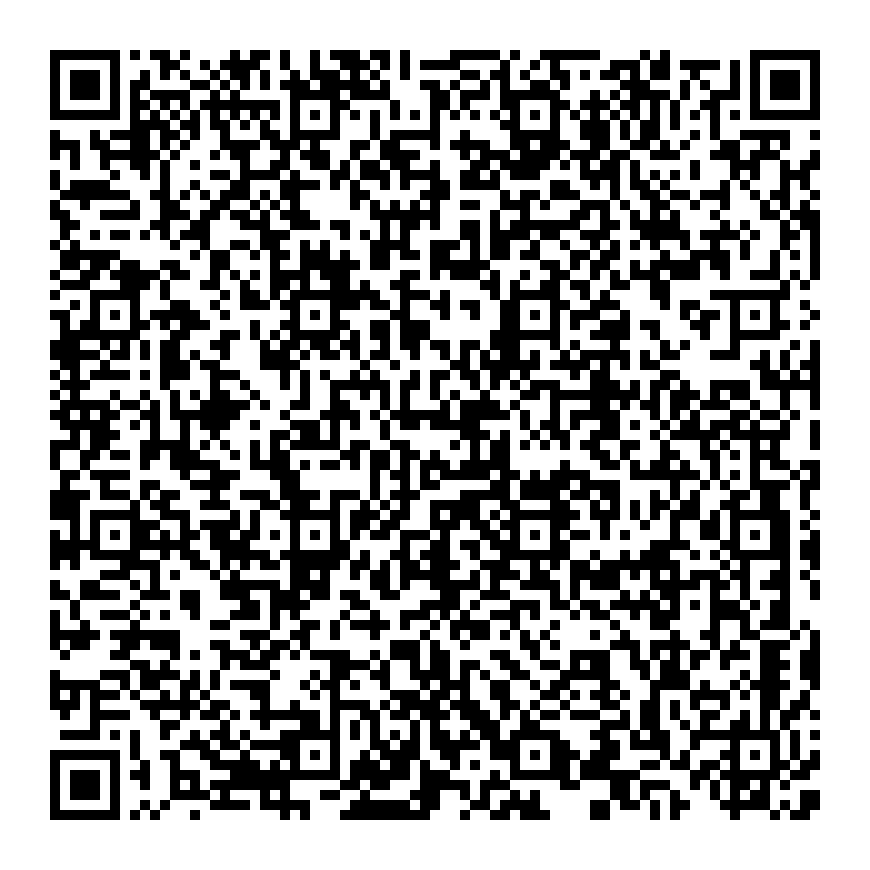

Connection message {'invitation_key': '7Ww9E8WKrbb22bnY2iWe3nLnnGm2jU9ni4CgRG8BFnj4', 'initiator': 'self', 'updated_at': '2020-09-11 13:19:27.022124Z', 'invitation_mode': 'once', 'routing_state': 'none', 'accept': 'auto', 'their_did': 'Tb12SLb8929gB71fTRJzsv', 'state': 'request', 'their_label': 'some-random-name', 'created_at': '2020-09-11 13:19:00.539801Z', 'connection_id': '7b693dfa-a99b-48b2-8d67-5b89b4ccf7c7'} 7b693dfa-a99b-48b2-8d67-5b89b4ccf7c7
Connection message {'invitation_key': '7Ww9E8WKrbb22bnY2iWe3nLnnGm2jU9ni4CgRG8BFnj4', 'initiator': 'self', 'my_did': '9HqU1v9fcMXYuTZTNQKF7i', 'updated_at': '2020-09-11 13:19:27.060965Z', 'invitation_mode': 'once', 'routing_state': 'none', 'accept': 'auto', 'their_did': 'Tb12SLb8929gB71fTRJzsv', 'state': 'response', 'their_label': 'some-random-name', 'created_at': '2020-09-11 13:19:00.539801Z', 'connection_id': '7b693dfa-a99b-48b2-8d67-5b89b4ccf7c7'} 7b693dfa-a99b-48b2-8d67-5b89b4ccf7c7


In [8]:
from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

# TODO - Add Trust Ping step

In [10]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])
        if item['state'] == 'active':
            connection_id = item['connection_id']

EXISTING CONNECTIONS
ConnectionID: 7b693dfa-a99b-48b2-8d67-5b89b4ccf7c7 Status: active
ConnectionID: a433d68c-e13f-4717-b1fc-ae10edb309d9 Status: invitation


In [26]:
print(connection_id)

cb87c19c-1fe6-480d-aa00-23768f0a3c63


In [27]:
credential_attributes = [
    {"name": "name", "value": "Bob"},
    {"name": "skill", "value": "researcher"},
    {"name": "age", "value": "21"}
]
print(credential_attributes)

[{'name': 'name', 'value': 'Bob'}, {'name': 'skill', 'value': 'researcher'}, {'name': 'age', 'value': '21'}]


In [28]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


{'issuer_did': 'FSYWpFZ1KtiHb7nRvWCmYm', 'auto_remove': True, 'credential_proposal': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/issue-credential/1.0/credential-preview', 'attributes': [{'name': 'name', 'value': 'Bob'}, {'name': 'skill', 'value': 'researcher'}, {'name': 'age', 'value': '21'}]}, 'connection_id': 'cb87c19c-1fe6-480d-aa00-23768f0a3c63', 'trace': False, 'comment': '', 'cred_def_id': 'FSYWpFZ1KtiHb7nRvWCmYm:3:CL:141433:default', 'schema_id': 'MGgoJXWbeupKsaHDa7s4fW:2:testabc:0.0.1', 'schema_name': 'testabc', 'schema_version': '0.0.1', 'schema_issuer_did': 'MGgoJXWbeupKsaHDa7s4fW'}
Handle Credentials
Credential exchange c410f27a-6823-4b09-a7c2-df66fd8f84eb, role: issuer, state: offer_sent
Offering: [{'name': 'name', 'value': 'Bob'}, {'name': 'skill', 'value': 'researcher'}, {'name': 'age', 'value': '21'}]
Credential exchange c410f27a-6823-4b09-a7c2-df66fd8f84eb, role: issuer, state: offer_sent
Handle Credentials
Credential exchange c410f27a-6823-4b09-a7c2-df66fd8f84eb, ro

In [29]:
response = await agent_controller.wallet.get_public_did()
print(response)
issuer_did = response["result"]["did"]

print("Request proof of Name and Age range from Bob")
#Set some variables

revocation = False
SELF_ATTESTED = True
exchange_tracing = False

#Enable this to ask for attributes to identity a user
req_attrs = [
    {"name": "name", "restrictions": [{"issuer_did": issuer_did}]},
    {"name": "skill", "restrictions": [{"issuer_did": issuer_did}]},
]

if revocation:
    req_attrs.append(
        {
            "name": "skill",
            "restrictions": [{"issuer_did": agent.did}],
            "non_revoked": {"to": int(time.time() - 1)},
        },
    )

if SELF_ATTESTED:
    # test self-attested claims
    req_attrs.append({"name": "country"},)

#Set predicates for Zero Knowledge Proofs
req_preds = [
    # test zero-knowledge proofs
    {
        "name": "age",
        "p_type": ">=",
        "p_value": 18,
        "restrictions": [{"issuer_did": issuer_did}],
    }
]

indy_proof_request = {
    "name": "Proof of Personal Information",
    "version": "1.0",
    "requested_attributes": {
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    "requested_predicates": {
        f"0_{req_pred['name']}_GE_uuid":
        req_pred for req_pred in req_preds
    },
}

if revocation:
    indy_proof_request["non_revoked"] = {"to": int(time.time())}

#proof_request = indy_proof_request
exchange_tracing_id = exchange_tracing
proof_request_web_request = {
    "connection_id": connection_id,
    "proof_request": indy_proof_request,
    "trace": exchange_tracing,
}

{'result': {'did': 'FSYWpFZ1KtiHb7nRvWCmYm', 'verkey': '8sVPz5MviyqPQXUxiRum7JK2PvFaRagKPcssnyYDv7Uw', 'public': True}}
Request proof of Name and Age range from Bob


In [30]:
response = await agent_controller.proofs.send_request(proof_request_web_request)
print(response)
presentation_exchange_id = response['presentation_exchange_id']
print("\n")
print(presentation_exchange_id)

Handle present proof
{'connection_id': 'cb87c19c-1fe6-480d-aa00-23768f0a3c63', 'state': 'request_sent', 'presentation_request': {'name': 'Proof of Personal Information', 'version': '1.0', 'requested_attributes': {'0_name_uuid': {'name': 'name', 'restrictions': [{'issuer_did': 'FSYWpFZ1KtiHb7nRvWCmYm'}]}, '0_skill_uuid': {'name': 'skill', 'restrictions': [{'issuer_did': 'FSYWpFZ1KtiHb7nRvWCmYm'}]}, '0_country_uuid': {'name': 'country'}}, 'requested_predicates': {'0_age_GE_uuid': {'name': 'age', 'p_type': '>=', 'p_value': 18, 'restrictions': [{'issuer_did': 'FSYWpFZ1KtiHb7nRvWCmYm'}]}}, 'nonce': '1010239133531018611640936'}, 'thread_id': '7259807a-1e22-468d-a036-3a6ce2146169', 'trace': False, 'presentation_exchange_id': 'ecb171c9-120d-4206-b4a8-4cbc6bd29c76', 'initiator': 'self', 'presentation_request_dict': {'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/present-proof/1.0/request-presentation', '@id': '7259807a-1e22-468d-a036-3a6ce2146169', 'request_presentations~attach': [{'@id': 'libin

Handle present proof
{'connection_id': 'cb87c19c-1fe6-480d-aa00-23768f0a3c63', 'verified': 'false', 'presentation': {'proof': {'proofs': [{'primary_proof': {'eq_proof': {'revealed_attrs': {'name': '93006290325627508022776103386395994712401809437930957652111221015872244345185', 'skill': '24214165878429772374367858032287880675266648921286067519661391650938186682695'}, 'a_prime': '23569995714460317045999365219558881376136802920823247562511440254423033992776020645316462170001564466163518609146888405921688686216476157431167125469843541130889246313032733063804188464488031794478699753202420803403837732817529262492341964517433742730496381747540422446328635958336978569903997242328998583025907736433741211568550126793262133551078914920450470050442631929927512816658867590574113611939905700129145909242282115804275126598610527700926754191820901188681590551731332927871883531893443741015172127462070643573118281861857490179252904666433590676930420209924935234624213432026549438685058861616490682340278',

In [85]:
response = await agent_controller.terminate()
print(response)

None


# The End!